# Finally, the correct Gi* approach

In [1]:
# Load packages 
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns         
import numpy as np
import os
import libpysal as lps 
from libpysal.weights import W 
from esda.getisord import G_Local
import pprint
from functools import reduce
from scipy.stats import zscore
from scipy import stats

# Remove max columns
pd.set_option('display.max_columns', None)

In [ ]:
# Import data
base_dir = "/capstone/justice40"
# base_dir = "~/MEDS/justice40/data-exploration"

# 2.0 communities files (from current CEJST website)
comm_v2 = pd.read_csv(os.path.join(base_dir, "data", "2.0-communities.csv"))

# Version 2.0 shapefile data
v2_geo = gpd.read_file(os.path.join(base_dir, "data", "2.0-shapefile-codebook", "usa", "usa.shp"))


/tmp/ipykernel_948471/2851883410.py:6: DtypeWarning: Columns (18,29,73,75,88,134) have mixed types. Specify dtype option on import or set low_memory=False.
  comm_v2 = pd.read_csv(os.path.join(base_dir, "data", "2.0-communities.csv"))


In [3]:
# Import data
base_dir = "/capstone/justice40"

# import complete data with geoda 
complete_geoda = gpd.read_file(os.path.join(base_dir, "data", "usa_high.geojson"))

In [ ]:
# Filter to racial/ethnic groups
comm_small = comm_v2[['Census tract 2010 ID', 'County Name', 'State/Territory', 'Percent Black or African American alone', 'Percent American Indian / Alaska Native', 'Percent Asian', 'Percent Native Hawaiian or Pacific', 'Percent two or more races', 'Percent White', 'Percent Hispanic or Latino', 'Percent other races', 'Total threshold criteria exceeded', 'Total categories exceeded', 'Identified as disadvantaged', 'Percentage of tract that is disadvantaged by area', 'Total population']]

# Rename columns
comm_small = comm_small.rename(columns={
    'Census tract 2010 ID': 'tract_id',
    'County Name':'county',
    'State/Territory':'state',
    'Percent Black or African American alone':'black',
    'Percent American Indian / Alaska Native':'american_indian_alaskan_native',
    'Percent Asian':'asian',
    'Percent Native Hawaiian or Pacific':'native_hawaiian_pacific_islander',
    'Percent two or more races':'two_or_more_races',
    'Percent White':'white',
    'Percent Hispanic or Latino':'hispanic_latino',
    'Percent other races':'other_races',
    'Total threshold criteria exceeded':'total_criteria', 
    'Total categories exceeded':'total_burdens', 
    'Identified as disadvantaged':'dac', 
    'Percentage of tract that is disadvantaged by area':'percent_area_dac', 
    'Total population':'total_population'
})

In [4]:
# comm_small = comm_v2[['Census tract 2010 ID', 'County Name', 'State/Territory', 'Total threshold criteria exceeded', 'Total categories exceeded', 'Identified as disadvantaged', 'Total population']]

# comm_small = comm_small.rename(columns={
#     'Census tract 2010 ID': 'tract_id',
#     'County Name':'county',
#     'State/Territory':'state',
#     'Total threshold criteria exceeded':'total_criteria', 
#     'Total categories exceeded':'total_burdens', 
#     'Identified as disadvantaged':'dac', 
#     'Total population':'total_population'
# })

# geometry, GEOID10
geo_join = v2_geo[['GEOID10', 'geometry']].rename(columns={'GEOID10':'tract_id'})
geo_join['tract_id'] =geo_join['tract_id'].astype('int64')

# Merge with geodf
complete = pd.merge(comm_small, geo_join, how='left', on='tract_id')

# Reassert GDF
complete =gpd.GeoDataFrame(complete)

# Drop geometry NAs
complete = complete[(complete.geometry.type == 'Polygon') |( complete.geometry.type == 'MultiPolygon')]

# Confirm our geometries are correct
complete.geom_type.unique()

array(['Polygon', 'MultiPolygon'], dtype=object)

In [5]:
# LISA

# Create weights using Queen method 
w = lps.weights.Queen(complete['geometry'])

# Run the Getis Ord test for burdens
gstar_burden = G_Local(complete['total_burdens'], w, transform='R', permutations=9999) # Set transform=R because the queen weights are row-standardized weights.

# Run the Getis Ord test for criteria
gstar_crit = G_Local(complete['total_criteria'], w, transform='R', permutations=9999)

/Users/hoyler/.conda/envs/justice40-env/lib/python3.10/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 40 disconnected components.
 There are 19 islands with ids: 10022, 10463, 11538, 16613, 20502, 20518, 20549, 20554, 32755, 33437, 58373, 58520, 72746, 72747, 72748, 72813, 72814, 72833, 73155.
  W.__init__(self, neighbors, ids=ids, **kw)


('WARNING: ', 10022, ' is an island (no neighbors)')
('WARNING: ', 10463, ' is an island (no neighbors)')
('WARNING: ', 11538, ' is an island (no neighbors)')
('WARNING: ', 16613, ' is an island (no neighbors)')
('WARNING: ', 20502, ' is an island (no neighbors)')
('WARNING: ', 20518, ' is an island (no neighbors)')
('WARNING: ', 20549, ' is an island (no neighbors)')
('WARNING: ', 20554, ' is an island (no neighbors)')
('WARNING: ', 32755, ' is an island (no neighbors)')
('WARNING: ', 33437, ' is an island (no neighbors)')
('WARNING: ', 58373, ' is an island (no neighbors)')
('WARNING: ', 58520, ' is an island (no neighbors)')
('WARNING: ', 72746, ' is an island (no neighbors)')
('WARNING: ', 72747, ' is an island (no neighbors)')
('WARNING: ', 72748, ' is an island (no neighbors)')
('WARNING: ', 72813, ' is an island (no neighbors)')
('WARNING: ', 72814, ' is an island (no neighbors)')
('WARNING: ', 72833, ' is an island (no neighbors)')
('WARNING: ', 73155, ' is an island (no neighb

/Users/hoyler/.conda/envs/justice40-env/lib/python3.10/site-packages/esda/getisord.py:527: RuntimeWarning: invalid value encountered in divide
  z_scores = (statistic - expected_value) / np.sqrt(expected_variance)
/Users/hoyler/.conda/envs/justice40-env/lib/python3.10/site-packages/esda/getisord.py:450: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Gs - self.EG_sim) / self.seG_sim
/Users/hoyler/.conda/envs/justice40-env/lib/python3.10/site-packages/esda/getisord.py:527: RuntimeWarning: invalid value encountered in divide
  z_scores = (statistic - expected_value) / np.sqrt(expected_variance)
/Users/hoyler/.conda/envs/justice40-env/lib/python3.10/site-packages/esda/getisord.py:450: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Gs - self.EG_sim) / self.seG_sim


In [6]:
# Adding the CORRECT gi star and p value to the new data frame
results = complete.copy()
results['gis_sim_burd'] = gstar_burden.z_sim 
results['p_sim_burd'] = gstar_burden.p_sim 

# Add indicator stats
results['gis_sim_ind'] = gstar_crit.z_sim 
results['p_sim_ind'] = gstar_crit.p_sim 

In [13]:
print(results['p_sim_burd'].describe())
print(results['p_sim_ind'].describe())

print(f"\n{results['gis_sim_burd'].describe()}")
print(results['gis_sim_ind'].describe())

count    73767.000000
mean         0.122452
std          0.150923
min          0.000100
25%          0.000100
50%          0.045200
75%          0.221500
max          0.500000
Name: p_sim_burd, dtype: float64
count    73767.000000
mean         0.129236
std          0.154913
min          0.000100
25%          0.000100
50%          0.053500
75%          0.235900
max          0.500000
Name: p_sim_ind, dtype: float64

count    73748.000000
mean        -0.014152
std          1.881101
min         -2.837669
25%         -1.377963
50%         -0.749122
75%          0.806917
max         10.839347
Name: gis_sim_burd, dtype: float64
count    73748.000000
mean        -0.029250
std          1.924806
min         -2.559832
25%         -1.263313
50%         -0.787628
75%          0.493654
max         13.690430
Name: gis_sim_ind, dtype: float64


In [8]:
# if results['gis_sim_burd'] < 0 :
#     results['p_sim_burd'] = -results['p_sim_burd']
# else:
#     results['p_sim_burd'] = results['p_sim_burd']

# Using .loc to apply the condition element-wise
results.loc[results['gis_sim_burd'] < 0, 'p_sim_burd'] = -results['p_sim_burd']
results.loc[results['gis_sim_burd'] >= 0, 'p_sim_burd'] = results['p_sim_burd']
# Don't know which row to set equal to 0. Becomes an issue later on with the color binning

results.loc[results['gis_sim_ind'] < 0, 'p_sim_ind'] = -results['p_sim_ind']
results.loc[results['gis_sim_ind'] >= 0, 'p_sim_ind'] = results['p_sim_ind']

In [29]:
complete_geoda.head()

,tract_id,county,state,black,american_indian_alaskan_native,asian,native_hawaiian_pacific_islander,two_or_more_races,white,hispanic_latino,other_races,total_criteria,total_burdens,dac,percent_area_dac,total_population,gisim_burd,psim_burd,gisim_ind,psim_ind,gisim_burd_geoda,id_burd_geoda,psim_burd_geoda,gisim_ind_geoda,id_ind_geoda,psim_ind_geoda,geometry
0,1001020100,Autauga County,Alabama,0.07,0.0,0.00,0.00,0.07,0.83,0.01,0.00,0,0.0,False,0,1993.0,-1.237826,-0.0001,-1.123479,-0.0001,0.0,2,0.0001,0.0,2,0.0001,"POLYGON ((-86.48196 32.49876, -86.48189 32.498..."
1,1001020200,Autauga County,Alabama,0.57,0.0,0.00,0.01,0.02,0.38,0.01,0.00,0,0.0,False,0,1959.0,-1.390661,-0.0001,-1.260418,-0.0001,0.0,2,0.0001,0.0,2,0.0001,"POLYGON ((-86.46828 32.4737, -86.468 32.47371,..."
2,1001020300,Autauga County,Alabama,0.24,0.0,0.00,0.00,0.02,0.65,0.06,0.06,0,0.0,False,0,3507.0,-1.237826,-0.0001,-1.123479,-0.0001,0.0,2,0.0001,0.0,2,0.0001,"POLYGON ((-86.46538 32.47372, -86.46597 32.473..."
3,1001020400,Autauga County,Alabama,0.05,0.0,0.00,0.00,0.03,0.89,0.01,0.00,0,0.0,False,0,3878.0,-1.237826,-0.0001,-1.123479,-0.0001,0.0,2,0.0001,0.0,2,0.0001,"POLYGON ((-86.43807 32.45349, -86.43812 32.453..."
4,1001020500,Autauga County,Alabama,0.18,0.0,0.03,0.00,0.02,0.70,0.04,0.00,0,0.0,False,0,10596.0,-1.237826,-0.0001,-1.123479,-0.0001,0.0,2,0.0001,0.0,2,0.0001,"POLYGON ((-86.4118 32.47416, -86.4118 32.47369..."


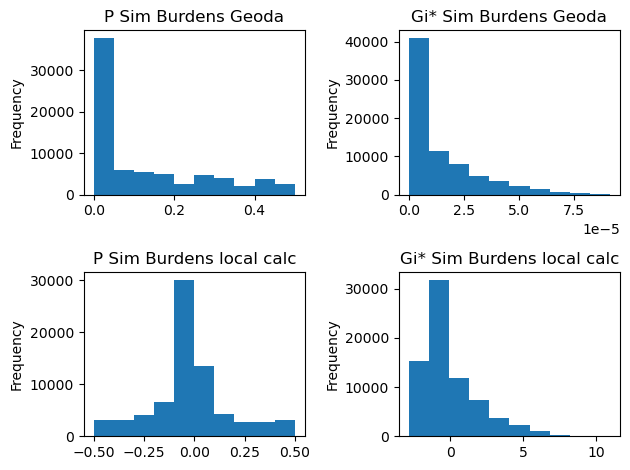

In [30]:
# Plot all 4 distributions
figure, axis = plt.subplots(2, 2)

# Regular burdens
complete_geoda['psim_burd_geoda'].plot(kind='hist', ax=axis[0,0])
axis[0,0].set_title('P Sim Burdens Geoda')

# Log burdens
complete_geoda['gisim_burd_geoda'].plot(kind='hist', ax=axis[0,1])
axis[0,1].set_title('Gi* Sim Burdens Geoda')

# Regular ind
complete_geoda['psim_burd'].plot(kind='hist', ax=axis[1,0])
axis[1,0].set_title('P Sim Burdens local calc')

# log ind
complete_geoda['gisim_burd'].plot(kind='hist', ax=axis[1,1])
axis[1,1].set_title('Gi* Sim Burdens local calc')

plt.tight_layout()
plt.show()


In [31]:
complete_test = complete_geoda.copy()

complete_test.loc[complete_test['id_burd_geoda'] == 2, 'psim_burd_geoda'] = -complete_test['psim_burd_geoda']
complete_test.loc[complete_test['id_burd_geoda'] == 1, 'psim_burd_geoda'] = complete_test['psim_burd_geoda']
# Don't know which row to set equal to 0. Becomes an issue later on with the color binning

complete_test.loc[complete_test['id_ind_geoda'] == 2, 'psim_ind_geoda'] = -complete_test['psim_ind_geoda']
complete_test.loc[complete_test['id_ind_geoda'] == 1, 'psim_ind_geoda'] = complete_test['psim_ind_geoda']

complete_test.loc[complete_test['id_burd_geoda'] == 2, 'gisim_burd_geoda'] = -complete_test['gisim_burd_geoda']
complete_test.loc[complete_test['id_burd_geoda'] == 1, 'gisim_burd_geoda'] = complete_test['gisim_burd_geoda']
# Don't know which row to set equal to 0. Becomes an issue later on with the color binning

complete_test.loc[complete_test['id_ind_geoda'] == 2, 'gisim_ind_geoda'] = -complete_test['gisim_ind_geoda']
complete_test.loc[complete_test['id_ind_geoda'] == 1, 'gisim_ind_geoda'] = complete_test['gisim_ind_geoda']

In [32]:
complete_test.head()

,tract_id,county,state,black,american_indian_alaskan_native,asian,native_hawaiian_pacific_islander,two_or_more_races,white,hispanic_latino,other_races,total_criteria,total_burdens,dac,percent_area_dac,total_population,gisim_burd,psim_burd,gisim_ind,psim_ind,gisim_burd_geoda,id_burd_geoda,psim_burd_geoda,gisim_ind_geoda,id_ind_geoda,psim_ind_geoda,geometry
0,1001020100,Autauga County,Alabama,0.07,0.0,0.00,0.00,0.07,0.83,0.01,0.00,0,0.0,False,0,1993.0,-1.237826,-0.0001,-1.123479,-0.0001,-0.0,2,-0.0001,-0.0,2,-0.0001,"POLYGON ((-86.48196 32.49876, -86.48189 32.498..."
1,1001020200,Autauga County,Alabama,0.57,0.0,0.00,0.01,0.02,0.38,0.01,0.00,0,0.0,False,0,1959.0,-1.390661,-0.0001,-1.260418,-0.0001,-0.0,2,-0.0001,-0.0,2,-0.0001,"POLYGON ((-86.46828 32.4737, -86.468 32.47371,..."
2,1001020300,Autauga County,Alabama,0.24,0.0,0.00,0.00,0.02,0.65,0.06,0.06,0,0.0,False,0,3507.0,-1.237826,-0.0001,-1.123479,-0.0001,-0.0,2,-0.0001,-0.0,2,-0.0001,"POLYGON ((-86.46538 32.47372, -86.46597 32.473..."
3,1001020400,Autauga County,Alabama,0.05,0.0,0.00,0.00,0.03,0.89,0.01,0.00,0,0.0,False,0,3878.0,-1.237826,-0.0001,-1.123479,-0.0001,-0.0,2,-0.0001,-0.0,2,-0.0001,"POLYGON ((-86.43807 32.45349, -86.43812 32.453..."
4,1001020500,Autauga County,Alabama,0.18,0.0,0.03,0.00,0.02,0.70,0.04,0.00,0,0.0,False,0,10596.0,-1.237826,-0.0001,-1.123479,-0.0001,-0.0,2,-0.0001,-0.0,2,-0.0001,"POLYGON ((-86.4118 32.47416, -86.4118 32.47369..."


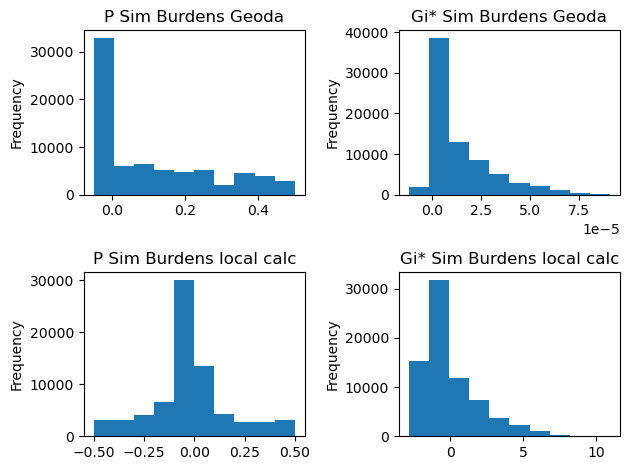

In [22]:
# Plot all 4 distributions
figure, axis = plt.subplots(2, 2)

# Regular burdens
complete_test['psim_burd_geoda'].plot(kind='hist', ax=axis[0,0])
axis[0,0].set_title('P Sim Burdens Geoda')

# Log burdens
complete_test['gisim_burd_geoda'].plot(kind='hist', ax=axis[0,1])
axis[0,1].set_title('Gi* Sim Burdens Geoda')

# Regular ind
complete_test['psim_burd'].plot(kind='hist', ax=axis[1,0])
axis[1,0].set_title('P Sim Burdens local calc')

# log ind
complete_test['gisim_burd'].plot(kind='hist', ax=axis[1,1])
axis[1,1].set_title('Gi* Sim Burdens local calc')

plt.tight_layout()
plt.show()


<Axes: ylabel='Frequency'>

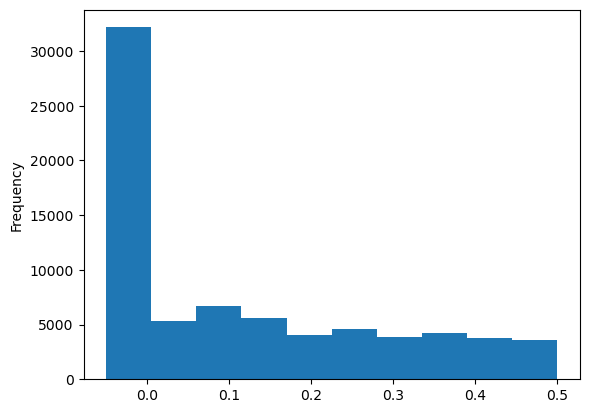

In [8]:
complete_geoda['psim_ind_geoda'].plot(kind='hist')

In [20]:
#  Results of number of burdens in each bin
results_95 = results[(abs(results['gis_sim_burd']) >=1.96) & (abs(results['gis_sim_burd']) < 2.58)]
results_99 = results[(abs(results['gis_sim_burd']) >=2.58)]

# Results for criteria
results_95_crit = results[(abs(results['gis_sim_ind']) >=1.96) & (abs(results['gis_sim_burd']) < 2.58)]
results_99_crit = results[(abs(results['gis_sim_ind']) >=2.58)]

# Print results
print(f"\nNumber of tracts in the 95th-99th percentile for burdens: {len(results_95)}")
print(f"Number of tracts in the 99th+ percentile for burdens: {len(results_99)}")

print(f"\nNumber of tracts in the 95th-99th percentile for criteria: {len(results_95_crit)}")
print(f"Number of tracts in the 99th+ percentile for criteria: {len(results_99_crit)}")


Number of tracts in the 95th-99th percentile for burdens: 3287
Number of tracts in the 99th+ percentile for burdens: 7779

Number of tracts in the 95th-99th percentile for criteria: 2366
Number of tracts in the 99th+ percentile for criteria: 7354


In [11]:
# Filter to only continental 48 states
state_names = ["Alabama", "Arkansas", "Arizona", "California", "Colorado", "Connecticut", "Delaware", "Florida", "Georgia", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", "Kentucky", "Louisiana", "Massachusetts", "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", "Mississippi", "Montana", "North Carolina", "North Dakota", "Nebraska", "New Hampshire", "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Virginia", "Vermont", "Washington", "Wisconsin", "West Virginia", "Wyoming"]

# Took out alaska and hawaii for ease of mapping
# results_cont = results[results['state'].isin(state_names)]
complete_geoda_cont = complete_geoda[complete_geoda['state'].isin(state_names)]

I have no idea how to get the colors to do what we want them to do. Also not sure if the "turning the p-value negative" thing worked. Tempted to try to do it like geoda did where they have a whole separate row with the `0, 1, 2` identifier. 

In [23]:
print(results['p_sim_burd'].describe())
print(results['p_sim_ind'].describe())

count    73767.000000
mean        -0.013234
std          0.193900
min         -0.496800
25%         -0.081200
50%         -0.000100
75%          0.015700
max          0.500000
Name: p_sim_burd, dtype: float64
count    73767.000000
mean        -0.033318
std          0.198973
min         -0.500000
25%         -0.111800
50%         -0.000100
75%          0.005200
max          0.481100
Name: p_sim_ind, dtype: float64


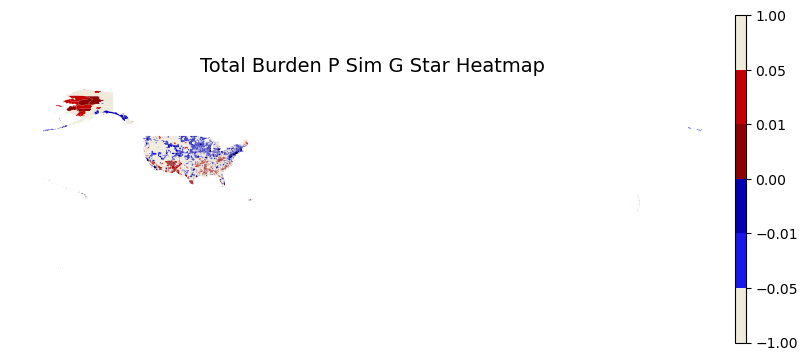

In [33]:
# Define 5 distinct colors
# colors = ["#0101b3", "#1818ed", "#efeada", "#c50000", "#8c0303"]  
colors = ["#efeada", "#1818ed", "#0101b3",  "#8c0303", "#c50000", "#efeada"]  

# # Create a discrete colormap
cmap = mcolors.ListedColormap(colors)

# # Define color boundaries
bounds = [-1, -0.05, -0.01, -1e-12,  0.01, 0.05, 1]
# bounds = [-3, -2.58, -1.96, -1.645, 1.645, 1.96, 2.58, 3]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Initialize figure
fig, ax = plt.subplots(figsize=(11,5))

# Remove axis for a cleaner map and set title
ax.axis('off')
ax.set_title(f"Total Burden P Sim G Star Heatmap",
            fontsize=14)

# Plot NY state and color by number of spills 
plot = complete_test.plot(ax=ax,
                column='psim_burd_geoda',
                cmap=cmap,
                norm=norm,
                legend=False)

# Get the colorbar from the plot
cbar = plot.get_figure().colorbar(plot.collections[0], ax=ax, 
orientation='vertical', pad=0, shrink=0.85, aspect=30)

# Modify the colorbar tick labels
# cbar.set_ticks([-2.78, -2.27, -1.8, 0, 1.8, 2.27, 2.78])
# cbar.set_ticklabels(['Cold Spot 99%', 'Cold Spot 95%', 'Not Significant', 'Hot Spot 95%', 'Hot Spot 99%']) 

plt.show()

In [34]:
complete_test.head()

,tract_id,county,state,black,american_indian_alaskan_native,asian,native_hawaiian_pacific_islander,two_or_more_races,white,hispanic_latino,other_races,total_criteria,total_burdens,dac,percent_area_dac,total_population,gisim_burd,psim_burd,gisim_ind,psim_ind,gisim_burd_geoda,id_burd_geoda,psim_burd_geoda,gisim_ind_geoda,id_ind_geoda,psim_ind_geoda,geometry
0,1001020100,Autauga County,Alabama,0.07,0.0,0.00,0.00,0.07,0.83,0.01,0.00,0,0.0,False,0,1993.0,-1.237826,-0.0001,-1.123479,-0.0001,-0.0,2,-0.0001,-0.0,2,-0.0001,"POLYGON ((-86.48196 32.49876, -86.48189 32.498..."
1,1001020200,Autauga County,Alabama,0.57,0.0,0.00,0.01,0.02,0.38,0.01,0.00,0,0.0,False,0,1959.0,-1.390661,-0.0001,-1.260418,-0.0001,-0.0,2,-0.0001,-0.0,2,-0.0001,"POLYGON ((-86.46828 32.4737, -86.468 32.47371,..."
2,1001020300,Autauga County,Alabama,0.24,0.0,0.00,0.00,0.02,0.65,0.06,0.06,0,0.0,False,0,3507.0,-1.237826,-0.0001,-1.123479,-0.0001,-0.0,2,-0.0001,-0.0,2,-0.0001,"POLYGON ((-86.46538 32.47372, -86.46597 32.473..."
3,1001020400,Autauga County,Alabama,0.05,0.0,0.00,0.00,0.03,0.89,0.01,0.00,0,0.0,False,0,3878.0,-1.237826,-0.0001,-1.123479,-0.0001,-0.0,2,-0.0001,-0.0,2,-0.0001,"POLYGON ((-86.43807 32.45349, -86.43812 32.453..."
4,1001020500,Autauga County,Alabama,0.18,0.0,0.03,0.00,0.02,0.70,0.04,0.00,0,0.0,False,0,10596.0,-1.237826,-0.0001,-1.123479,-0.0001,-0.0,2,-0.0001,-0.0,2,-0.0001,"POLYGON ((-86.4118 32.47416, -86.4118 32.47369..."


In [35]:
complete_test.to_file('../data/usa_high.geojson', index=False, driver='GeoJSON')